# Click detection
In the following echolocation clicks should be extracted from recorded time series. The particular dataset contains Cuvier's beaked whale data recorded in the Mediterranean Sea using a passive acoustic recorder. The data are available from "Mobysound" 

## Load data
A selected time window of 10 s is loaded for inspection.

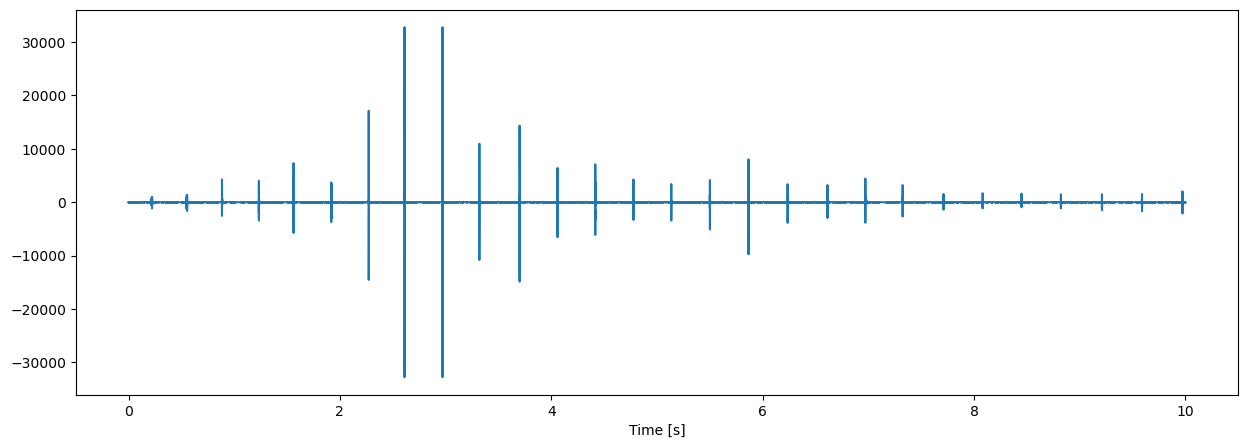

In [89]:
import numpy as np
import matplotlib.pyplot as plt

import wave, struct

# load some data from wav files
def wavLoad(fname,t1,dt):
    wf = wave.open(fname, 'rb')
    nframes=wf.getnframes()
    nsw=wf.getsampwidth()
    fs=wf.getframerate()
    nch=wf.getnchannels()
    nbuf=int(dt*fs)
    wf.setpos(int(t1*fs))
    buf=wf.readframes(nbuf)
    wf.close()
    data = np.array(struct.unpack('{n}h'.format(n=nbuf*nch),buf))
    return data,fs,nch

# data from https://www.mobysound.org/odontocetes/Ziphius_Italy-Annotated.zip
# copied to ./Data/
data,fs,nch=wavLoad("./Data/zc06_204a22410-24210.wav",4,10)

tt=np.arange(np.shape(data)[0])/fs
fig = plt.figure("figure.figsize",[15,5])
plt.plot(tt,data)
plt.xlabel("Time [s]");


The timeseries shows a typical echolocation click train of odontocetes. Clicks are emitted in a more or less regular fashion. The click amplitude as received by an acoustic recorder are mostly moderate but for short periods of time can become much stronger as evident in above figure. 

This phenomenon is typical for echolocation clicks where the animal emits highly focused clicks in forward directions scanning the environment in all possible directions. Whenever the animal is pointing the echolcation sound beam towards the acoustic recorder, the received click amplitude can become strong, but most of the time the animal is searching in other directions and the received click amplitude is much weaker.

## Click detection

### Supporting functions

In [90]:
from numba import jit

@jit(nopython=True,cache=True)
def peak1(xx,leak):
    ndat=len(xx)
    yy=1.0*xx
    for ii in range(1,ndat):
        yy[ii]=np.maximum(xx[ii],yy[ii-1]*leak)
    return yy

@jit(nopython=True,cache=True)
def pageTest1(zz,th,bb,aa,nt):
    ee=0*zz
    dd=0*zz
    nn=0*zz
    sn=0*zz

    no=np.sum(zz[:100],0)/100
    nn[0]=no
    #
    sn[0]=zz[0]/nn[0]
    #
    ndat=len(zz)
    
    it=0
    for ii in range(1,ndat):
        sn[ii]=zz[ii]/nn[ii-1]
        ee[ii]= ee[ii-1]+(sn[ii]-bb)
        if (ee[ii]>th):
            ee[ii]=th
            dd[ii]=1
            if ii-it>=nt:
                ee[it:ii]=th
                dd[it:ii]=1
        if (ee[ii]<0):
            ee[ii]=0
            nn[ii]=nn[ii-1]+aa*(zz[ii]-nn[ii-1])
            it=ii
        else:
            nn[ii]=nn[ii-1]
                
    return dd,nn

Click detections are obtained using first a leaky peak filter followed by a page-test transient detector

In [91]:
yy=peak1(data**2,0.97)
dd,nn=pageTest1(yy,20,6,1e-3,10)

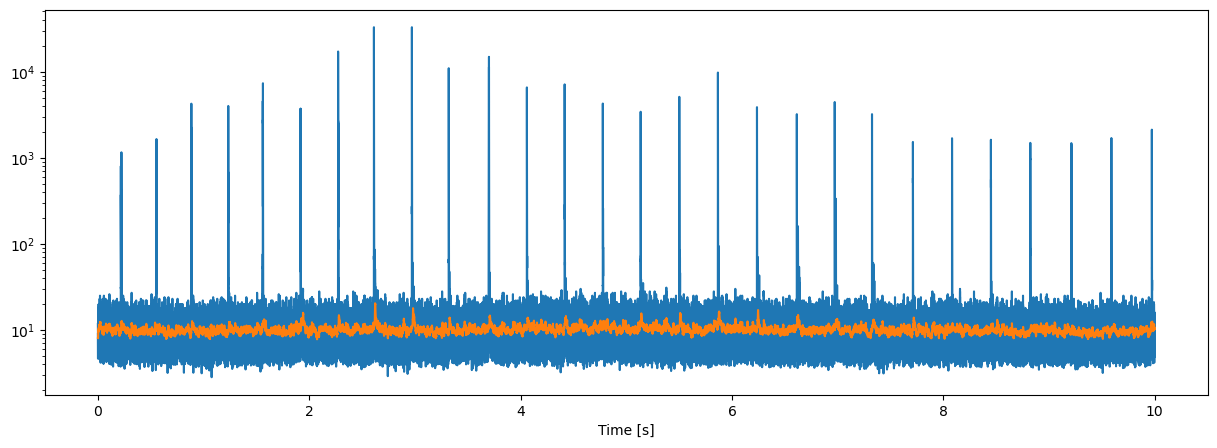

In [92]:
fig = plt.figure("figure.figsize",[15,5])
plt.semilogy(tt,np.sqrt(yy),tt,np.sqrt(nn))
plt.xlabel("Time [s]");


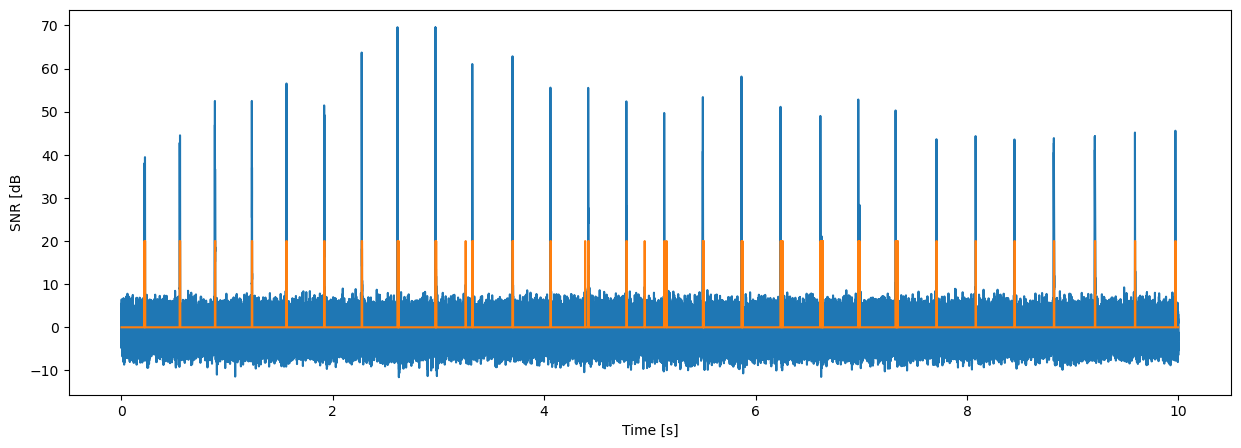

In [93]:

fig = plt.figure("figure.figsize",[15,5])
plt.plot(tt,10*np.log10(yy/nn))
plt.plot(tt,20*dd)
plt.xlabel("Time [s]");
plt.ylabel('SNR [dB');

## Load and process beaked whale data

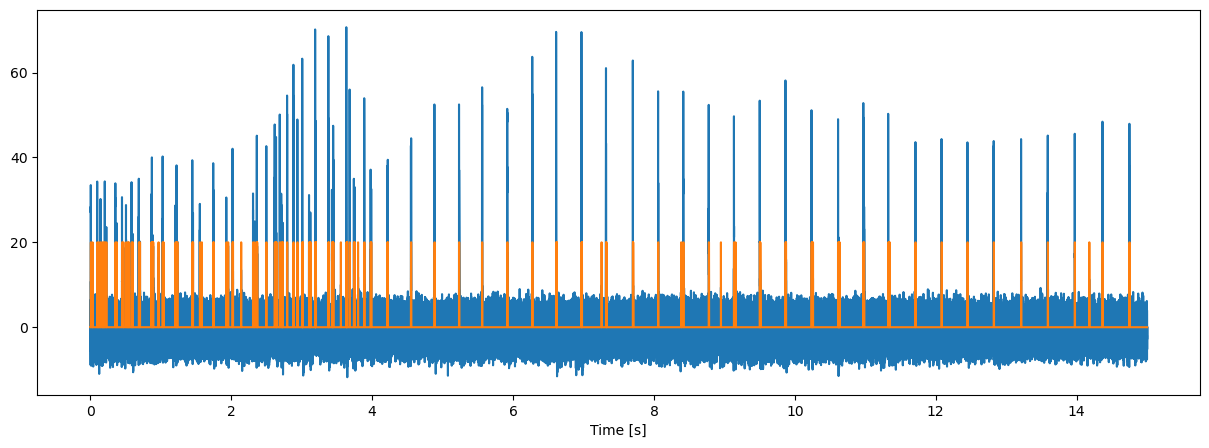

In [94]:
data,fs,nch=wavLoad("./Data/zc06_204a22410-24210.wav",0, 15)
tt=np.arange(np.shape(data)[0])/fs

yy=peak1(data**2,0.97)
dd,nn=pageTest1(yy,20,6,1e-3,10)

fig = plt.figure("figure.figsize",[15,5])
plt.plot(tt,10*np.log10(yy/nn))
plt.plot(tt,20*dd)
plt.xlabel("Time [s]");


Echolocation click trains are sequences if clicks emitted in a highly correlated fashion, that is, the interval between two consecutive clicks (the Inter-Click_Interval, or ICI) is nearly constant or slowly vaying and to some extend characteristic for the odontocete species.

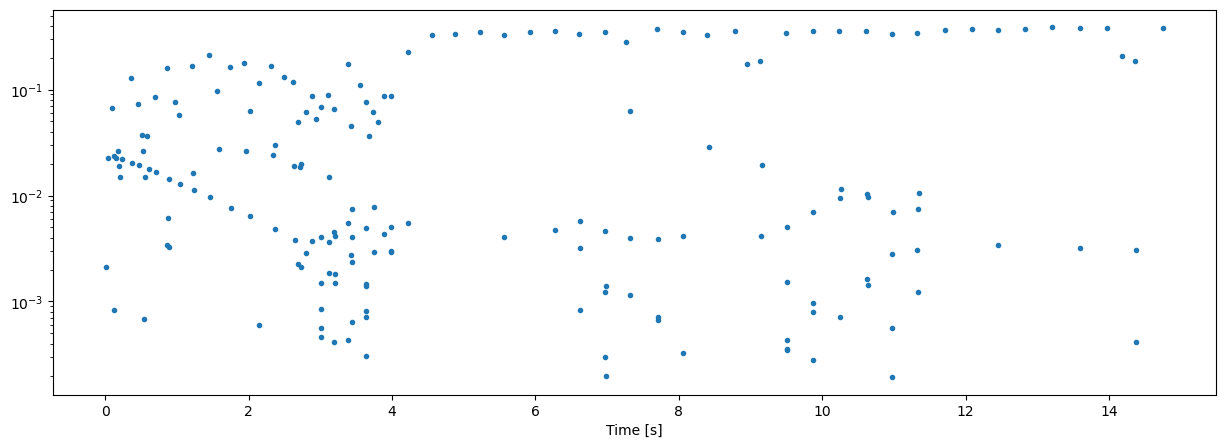

In [95]:
t1 = np.diff(dd,1,0,prepend=[0])
tcl= tt[t1>0]
ici = np.diff(tcl)

fig = plt.figure("figure.figsize",[15,5])
plt.semilogy(tcl[1:],ici,'.')
plt.xlabel("Time [s]");

The above plot is an Inter-Detection-Interval (IDI) plot, where all detection are used unlabeled. To obtain the desired ICI, one needs to label these detections properly.

There are three categories of labels
- click
- boundary reflection of clicks
- interfering detections

In case that multiple animals, the interfering detections may be associated with echolocation clicks of another animal.

This is a classical data association problem that can be solved with statistical methods.

## Extract clicks and click features

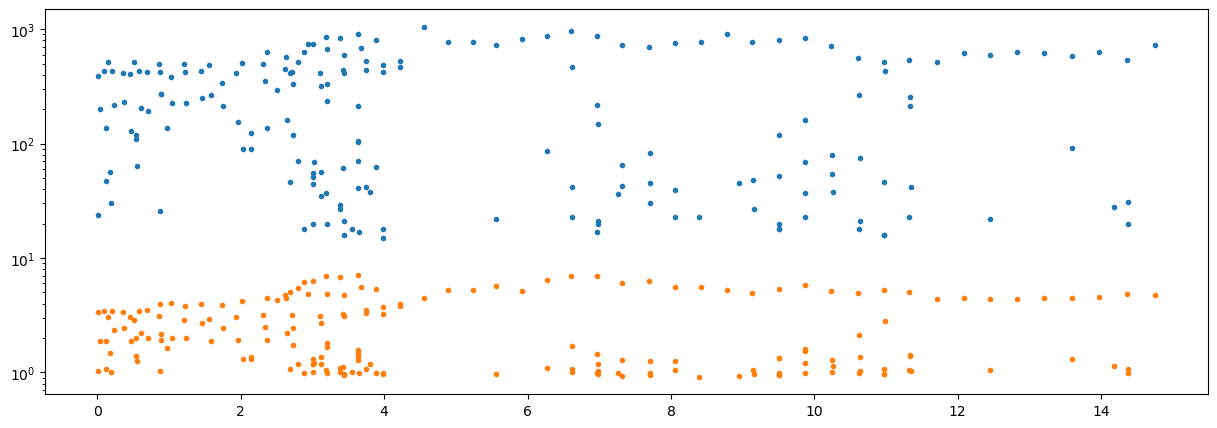

In [96]:
# search for start and stop of detections
# force start and stop at beginning and end of detections
dd[0]=0
dd[-1]=0
#
id=dd[1:]-dd[:-1]
ip=np.where(id>0)[0] # start of detection
im=np.where(id<0)[0] # stop of detection

det=np.vstack((ip,im))

ndets=np.shape(det)[1]

nc=3
Labels=["TCL","LEN","SNR"]
E=np.zeros((nc,ndets))
E[0,:] = tt[ip]
E[1,:] = det[1,:]-det[0,:]  # LEN
for ii in range(ndets):
    ix=range(det[0,ii],det[1,ii])
    E[2,ii]= np.log10(np.max(yy[ix]/nn[ix])) # SNR

fig = plt.figure("figure.figsize",[15,5])
plt.semilogy(E[0,:],E[1:,:].T,'.');

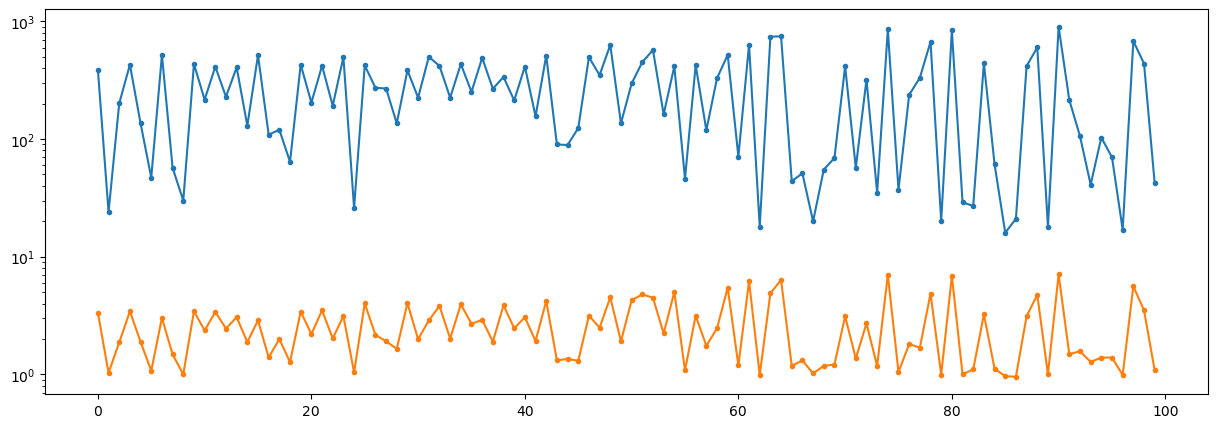

In [97]:
fig = plt.figure("figure.figsize",[15,5])
plt.semilogy(E[1:,:100].T,'.-');

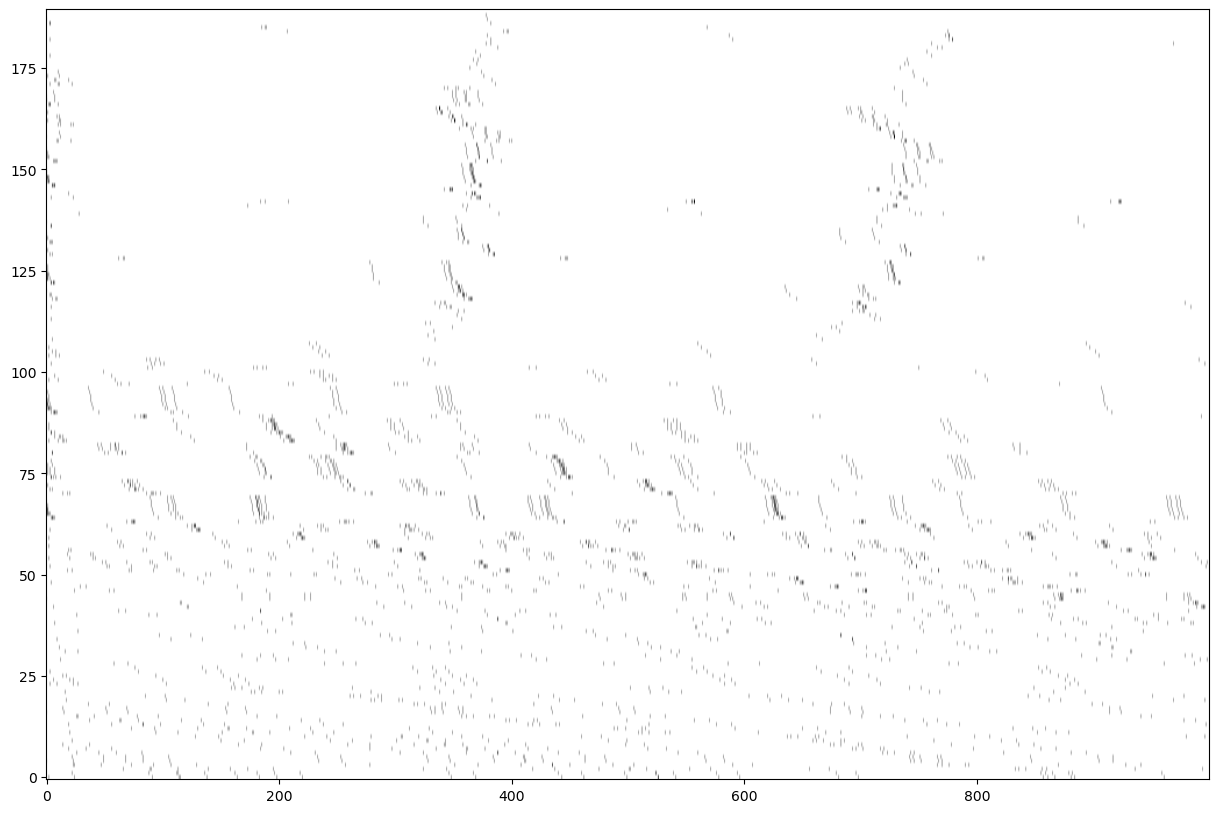

In [98]:
nd=np.shape(E)[1]
n2=1000
A=np.zeros((nd,n2))
for ii in range(nd):
    for jj in range(ii+1,nd):
        dt=E[0,jj]-E[0,ii]
        if dt<1:
            kk=int(dt*n2)
            if kk<n2:
                A[ii,kk]+=1

fig=plt.figure('figure.figsize',[15,10])
im1=plt.imshow(A,origin='lower',cmap=plt.cm.gray_r, aspect='auto')

In the following we try to track the strongest SNR peaks assuming that they are a good proxy for clicks.

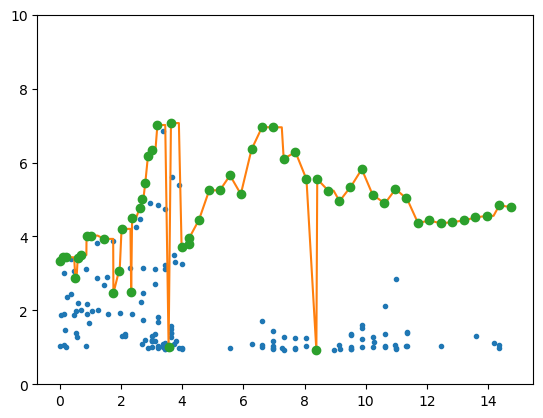

In [108]:
tcl=E[0,:].T
snr=E[2,:].T

snx=snr.copy()
tcx=tcl.copy()
for ii in range(1,len(snx)):
    if (snx[ii]<snx[ii-1]):
        if (tcx[ii]-tcx[ii-1]<0.3):
            tcx[ii]=tcx[ii-1]
            snx[ii]=snx[ii-1]

plt.plot(tcl,snr,'.')
plt.plot(tcl,snx)
io=np.where(snx==snr)
plt.plot(tcl[io],snr[io],'o')
plt.ylim(0,10);


(55, 1)
190
(55, 1, 10)
[[   0.0063  389.        3.3482    0.        1.        0.    ]
 [   0.0974  429.        3.4317    0.0664    1.        0.0911]
 [   0.2048  435.        3.4353    0.015     1.        0.1074]
 [   0.5062  516.        2.8786    0.0374    1.        0.3014]
 [   0.5848  430.        3.4163    0.0368    1.        0.0786]
 [   0.688   420.        3.4984    0.0853    1.        0.1032]
 [   0.8736  423.        4.0005    0.0061    1.        0.1857]
 [   1.026   384.        4.0226    0.0581    1.        0.1524]
 [   1.4472  434.        3.9339    0.2124    1.        0.4212]
 [   1.752   213.        2.4612    0.0077    1.        0.3048]
 [   1.9296  414.        3.0561    0.1776    1.        0.1776]
 [   2.0183  512.        4.2049    0.0625    1.        0.0887]
 [   2.3331  350.        2.4923    0.0242    1.        0.3148]
 [   2.363   631.        4.5123    0.0299    1.        0.0299]
 [   2.6165  451.        4.7759    0.1184    1.        0.2535]
 [   2.6881  415.        5.0102

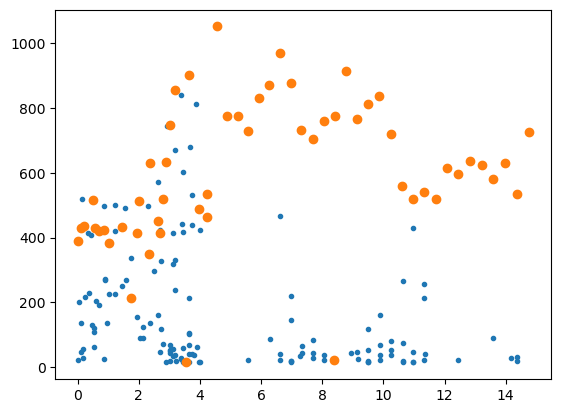

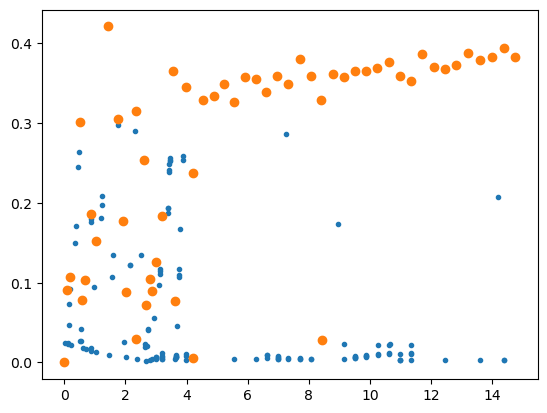

In [100]:
tcl=E[0,:].T
clx=E[1,:].T
snr=E[2,:].T

np.shape(E)
F=np.zeros((190,10))
F[:,0]=tcl
F[:,1]=clx
F[:,2]=snr
F[1:,3]=tcl[1:]-tcl[:-1]
ncl=np.shape(F)[0]

idet=np.array(io).T
#idet = np.array(np.where((snr>2) & (clx>500))).T
print(np.shape(idet))
print(ncl)
#idet=(0,3,9,11,13,15,19)
F[idet,4]=1

for ii in range(1,ncl):
    if F[ii-1,4]==1:
        F[ii,5]= F[ii,3]
    else:
        F[ii,5]= F[ii-1,5]+F[ii,3]

for ii in range(1,ncl):
    if F[ii,4]==1: F[ii,6]= F[ii,5]

print(np.shape(F[idet,:]))
print(np.array_str(np.squeeze(F[idet,:6]), precision=4, suppress_small=True))

plt.plot(F[:,0],F[:,1:2],'.')
plt.plot(F[idet,0],F[idet,1],'o')
#plt.xlim(0,2)
plt.show()
plt.plot(F[:,0],F[:,5],'.');
plt.plot(F[idet,0],F[idet,6],'o');
#plt.ylim(0,0.5);
#plt.xlim(0,2);

[0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1
 2 3 4 0 1] 18988.49102369028


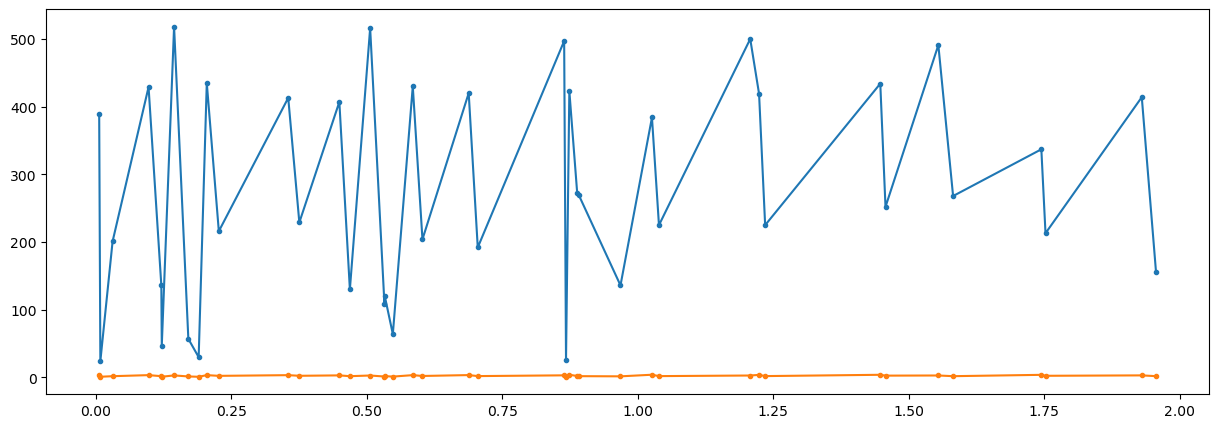

(array([26], dtype=int64),) [1 2 2 1 2 2 1 2 2 1 2 1 2 1 2 1 2 2 2 1 2 1 2 1 2 1 4 3 2 1 2 1 1 2 1 3 1
 3 1 2 1 2] 18988.49102369028 (5, 2)
(array([26, 27, 38], dtype=int64),) [1 0 3 1 2 0 1 0 0 1 3 1 3 1 2 1 2 2 0 1 3 1 2 1 0 1 4 4 2 1 3 1 1 3 1 3 1
 3 4 3 1 2] 0.1487966343315108 (5, 2)


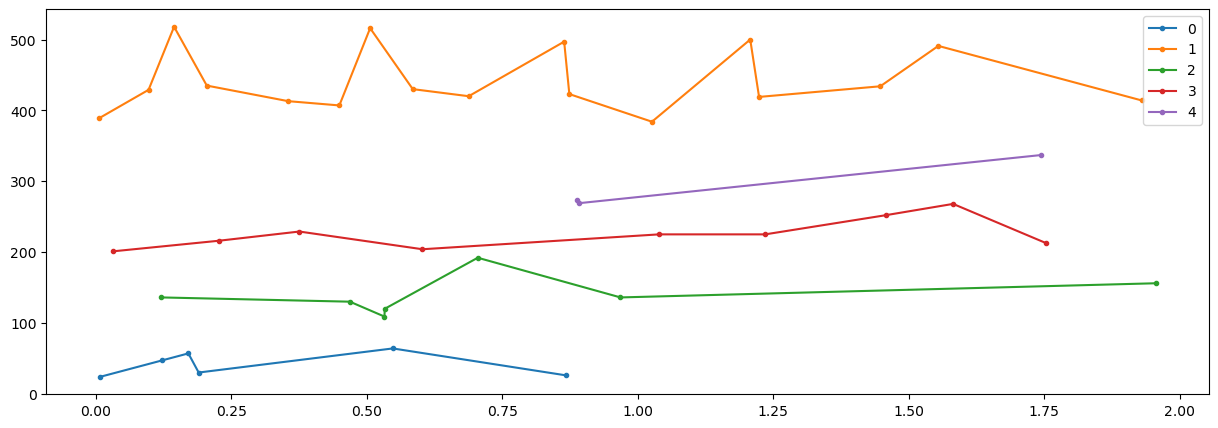

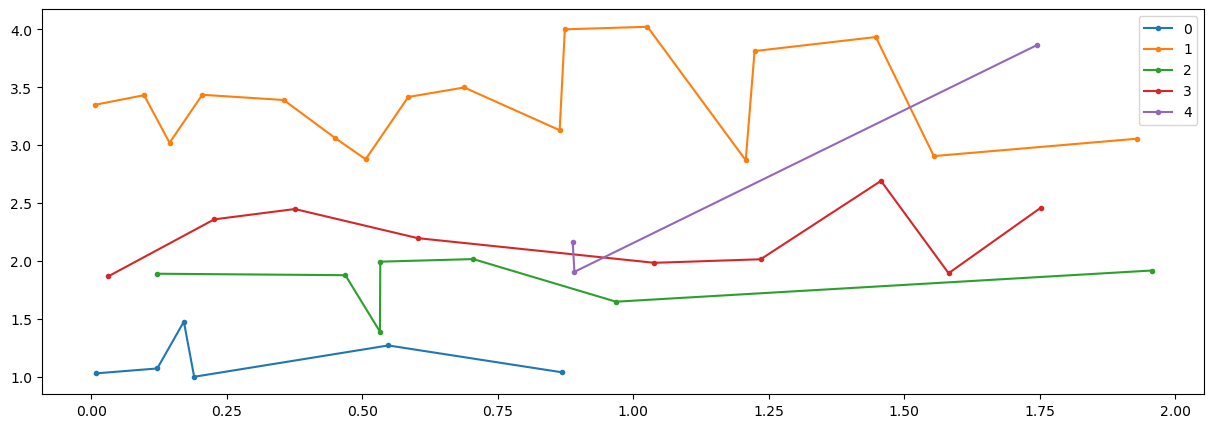

In [101]:
# modified after https://www.askpython.com/python/examples/k-means-clustering-from-scratch

#Importing required modules
import numpy as np
from scipy.spatial.distance import cdist 
n1=np.where(E[0,:]<2)[0]

t=E[0,n1].T
x=E[1:,n1].T
k=5
nit=10


# initialize labels
nd=np.shape(x)[0]

labels = np.mod(range(nd),k)
centroids = x[[range(k)][0], :] 
variances = 0*centroids

def mCluster(x,labels,k,centroids,variances):
    for ii in range(k):
        ni=labels==ii
        if np.sum(ni)>0:
            tmp=x[ni]
            m1= tmp.mean(axis=0) 
            m2= (tmp*tmp).mean(axis=0)
        else:
            m1=0
            m2=0
        centroids[ii,:]=m1           # centroid
        variances[ii,:]=m2-m1**2     # variance
    return centroids,variances

centroids,variances=mCluster(x,labels,k,centroids,variances)
print(labels,variances.trace())

fig = plt.figure("figure.figsize",[15,5])
plt.plot(t,x,'.-')
plt.show()

#Repeating the above steps for a defined number of iterations
best=np.Inf	
for ni in range(nit): 
    #Updating Centroids by taking mean of Cluster it belongs to
    centroids,variances=mCluster(x,labels,k,centroids,variances)
    ##
    # if variance get worth break loop
    inert=variances.trace()
    if inert >= best: break
    best=inert
    #
    distances = cdist(x, centroids ,'euclidean')
    labels = np.array([np.argmin(ii) for ii in distances])
    for ii in range(k):
        ni=np.where(labels==ii)
        if len(ni)>0:
            tcl=tt[ni]
            if len(ni)>1:
                ici=tcl[1:]-tcl[:-1]


    print(ni,labels,best,np.shape(centroids))

for idat in range(nc-1):
    fig = plt.figure("figure.figsize",[15,5])
    u_labels = np.unique(labels)
    for label in u_labels:
        plt.plot(t[labels == label] , x[labels == label,idat],'.-', label = label)
    plt.legend()
    plt.show()


In [102]:
def doClickTrain(inp,tcl,pcl,icm,cmin):
    # inp:
    # tcl: click time
    # pcl: click power
    # icm:
    # cmin: min clik interval (e.g. 0.15)
    K=len(icm);
    #
    in0=0*icm;
    in1=0*icm;
    in2=0*icm;
    #=============================================================
    for nn in range(10):
        count=0;
    #
        for ii in range(1,len(tcl)):
            # if we have a free click
            if inp[ii,10]==0:
                dd1k=np.inf+0*icm;
                dd2k=np.inf+0*icm;
                ij=len(tcl);
                for kk in range(K):
                    # find next click
                    for jj in range(ii+1,len(tcl)):
                        if abs(inp(jj,1))==1+2*(kk-1):
                            ij=jj; 
                            break
                # check if still space for new click in kk
                if in0[kk]>0:
                    if tcl[ij]-tcl[in0[kk]]<1.5:
                        continue
                #
                if in2[kk]>0:
                    icin=tcl[in0[kk]]-tcl[in1[kk]];
                    if icin<0: icin=1/3;
                    ddkx=np.abs(tcl[ii]-tcl[in2[kk]]-3*(icin));
                    if ddkx<dd1k[kk]: dd1k[kk]=ddkx;
                
                if dd1k[kk]>cmin and in1[kk]>0:
                    icin=tcl[in0[kk]]-tcl[in1[kk]];
                    if icin<0: icin=1/2; 
                    ddkx=np.abs(tcl[ii]-tcl[in1[kk]]-2*(icin));
                    if ddkx<dd1k[kk]: dd1k[kk]=ddkx; 
                
                if dd1k[kk]>cmin and in0[kk]>0:
                    icin=1;
                    ddkx=np.abs(tcl[ii]-tcl[in0[kk]]-icin);
                    if ddkx<dd1k(kk): dd1k[kk]=ddkx;
                
                if in1[kk]>0:
                    dpcl=pcl[in0[kk]]-pcl[in1[kk]];
                    dd2k[kk]=np.abs(pcl[ii]-pcl[in1[kk]]-2*dpcl);
                elif in0[kk]>0:
                    dd2k[kk]=abs(pcl[ii]-pcl[in0[kk]]);

            # do we have a best allocation?
            [d1x,k1x]=np.min(dd1k);
            [d2x,k2x]=np.min(dd2k);
            if k1x==k2x: #have same best allocation
                kx=k1x;
                if d1x<cmin: #have a good click
                    inp[ii,:]=[1+2*(kx-1),ii,0];
                    count=count+1;
                
#            else: # have conflicting allocations
                # for the moment skip
 #               [d1x k1x,d2x,k2x pcl(ii) pcl(in0(kk))]

        if np.mod(np.abs(inp(ii,1))-1,2) ==0: # have marked click
            kx=1+np.floor((np.abs(inp(ii,1))-1)/2);
            in2[kx]=in1[kx]; # so shift all back
            in1[kx]=in0[kx];
            in0[kx]=ii;
        
        
        if count==0: 
            break
    return inp

